In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [33]:
function hgf_timeslice(model, zt_prev, xt_prev, z_precision, y_precision, kfunction, approximation)
    
    zprec = constvar(model, :zprec, z_precision)
    zt    = randomvar(model, :zt)
    
    z_transition = make_node(model, MvNormalMeanPrecision, zt, zt_prev, zprec, factorisation = ((1, 2),(3,)))
    
    xt = randomvar(model, :xt)
    
    gcv = make_node(model, KernelGCV, KernelGCVMetadata(kfunction, approximation), xt, xt_prev, zt)
    
    yprec = constvar(model, :yprec, y_precision)
    y     = datavar(model, :y, Dirac{Vector{Float64}})
    
    obs = make_node(model, MvNormalMeanPrecision, y, xt, yprec)
    
    return (zt, xt, y, gcv, z_transition)
end

function hgf(n, iters, ndim, data, z_precision, y_precision, kfunction, approximation)
    model = Model()
    
    zs = Vector{RandomVariable}(undef, n)
    xs = Vector{RandomVariable}(undef, n)
    ys = Vector{DataVariable}(undef, n)
    
    zt_1_mean = datavar(model, :zt_1_mean, Dirac{Vector{Float64}})
    zt_1_prec = datavar(model, :zt_1_prec, Dirac{PDMat{Float64, Matrix{Float64}}})
    zt_1      = randomvar(model, :zt_1)
    
    xt_1_mean = datavar(model, :xt_1_mean, Dirac{Vector{Float64}})
    xt_1_prec = datavar(model, :xt_1_prec, Dirac{PDMat{Float64, Matrix{Float64}}})
    xt_1      = randomvar(model, :xt_1)
    
    zt_1_prior = make_node(model, MvNormalMeanPrecision, zt_1, zt_1_mean, zt_1_prec)
    xt_1_prior = make_node(model, MvNormalMeanPrecision, xt_1, xt_1_mean, xt_1_prec) 
    
    prev_zt_n = zt_1
    prev_xt_n = xt_1
    
    mz = Vector{MvNormalMeanPrecision}(undef, n)
    mx = Vector{MvNormalMeanPrecision}(undef, n)
    gcv = Vector{FactorNode}(undef, n)
    z_transition = Vector{FactorNode}(undef, n)
    
    mz_subs = Vector{Teardown}(undef, n)
    mx_subs = Vector{Teardown}(undef, n)
    
    ms_scheduler = PendingScheduler()

    for i in 1:n
        zt_n, xt_n, y_n, gcv_n, z_transition_n = hgf_timeslice(model, prev_zt_n, prev_xt_n, z_precision, y_precision, kfunction, approximation)
        
        zs[i] = zt_n
        xs[i] = xt_n
        ys[i] = y_n
        gcv[i] = gcv_n
        z_transition[i] = z_transition_n
        
        mz_subs[i] = subscribe!(getmarginal(zt_n) |> schedule_on(ms_scheduler), (t) -> mz[i] = getdata(t))
        mx_subs[i] = subscribe!(getmarginal(xt_n) |> schedule_on(ms_scheduler), (t) -> mx[i] = getdata(t))
    
        prev_zt_n = zt_n
        prev_xt_n = xt_n
    end
    
    activate!(model)
    
    foreach(gcv) do gcv_node
        setmarginal!(gcv_node, :y_x, MvNormalMeanPrecision(zeros(2 * ndim), PDMat(Matrix(Diagonal(1.0 * ones(2 * ndim))))))
        setmarginal!(gcv_node, :z, MvNormalMeanPrecision(zeros(ndim), PDMat(Matrix(Diagonal(1.0 * ones(ndim))))))
    end
    
    foreach(z_transition) do z_transition_node
        setmarginal!(z_transition_node, :out_μ, MvNormalMeanPrecision(zeros(2 * ndim), PDMat(Matrix(Diagonal(1.0 * ones(2 * ndim))))))
    end
    
    # Initial messages
    prior_zt = MvNormalMeanPrecision(zeros(ndim), PDMat(Matrix(Diagonal(100.0 * ones(ndim)))))
    prior_xt = MvNormalMeanPrecision(zeros(ndim), PDMat(Matrix(Diagonal(100.0 * ones(ndim)))))
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    progress = ProgressMeter.Progress(iters)

    for _ in 1:iters
        
        for i in 1:n
            update!(ys[i], data[i])
        end
        
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_prec, precision(prior_xt))
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_prec, precision(prior_zt))
        
        release!(fe_scheduler)
        
        ProgressMeter.next!(progress)
    end
    
    release!(ms_scheduler)
 
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [58]:
import ReactiveMP: @rule, @marginalrule, score

using PDMats

import ForneyLab

@rule(
    form => Type{ <: MvNormalMeanPrecision },
    on   => :μ,
    vconstraint => Marginalisation,
    messages => (m_out::ReactiveMP.FnWithApproximation, ),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        vindex = ReactiveMP.varindex(__node, :μ)
        vin    = @inbounds ReactiveMP.variables(__node)[vindex]
        return vin.m_in |> take(1) |> map(MvNormalMeanPrecision, (m_μ) -> begin
            inv_q_Λ        = inv(mean(q_Λ))
            msg_fwd        = MvNormalMeanPrecision(mean(m_μ), inv(cov(m_μ) + inv_q_Λ))
            multiplication = getdata(as_message(msg_fwd) * as_message(m_out))
            
            m, c = mean(multiplication), cov(multiplication)
            return MvNormalMeanPrecision(m, inv(c + inv_q_Λ))
        end)
    end
)

@marginalrule(
    form => Type{ <: MvNormalMeanPrecision },
    on   => :out_μ,
    messages => (m_out::ReactiveMP.FnWithApproximation, m_μ::MvNormalMeanPrecision),
    marginals => (q_Λ::Dirac, ),
    meta => Nothing,
    begin
        d = ndims(m_μ)
        
        m_mean_mean, m_mean_cov = mean(m_μ), cov(m_μ)
        
        Wbar = mean(q_Λ)
        
        W = [ Wbar -Wbar; -Wbar Wbar ]

        logpdf = getdata(m_out).fn

        msg_fwd    = MvNormalMeanPrecision(mean(m_μ), inv(cov(m_μ) + inv(mean(q_Λ))))
        v_mean_inv = precision(m_μ)

        l(z) = @views -0.5 * z'*W*z - 0.5 * (z[d+1:end] - m_mean_mean)' * v_mean_inv * (z[d+1:end] - m_mean_mean) + logpdf(z[1:d])

        #Expansion point
        point1 = mean(as_message(msg_fwd) * as_message(m_out))

        try
            # @show point1
            m_joint, v_joint = ForneyLab.NewtonMethod(l, [ point1; m_mean_mean ])
            return MvNormalMeanPrecision(m_joint, inv(PDMat(Matrix(Hermitian(v_joint)))))
        catch e
            # println("fallback")
            # println(e)
            # error("fallback")
            # Use cubature as a fallback
            cubature = getdata(m_out).approximation
            mean, cov = ReactiveMP.approximate_meancov(cubature, (x) -> exp(logpdf(x)), msg_fwd)
            
            approx_prec = [ inv(cov) + Wbar -Wbar; -Wbar inv(m_mean_cov) + Wbar ]
            approx_mean = inv(approx_prec) * [ inv(cov) * mean; inv(m_mean_cov) * m_mean_mean ]
            
            return MvNormalMeanPrecision(approx_mean, approx_prec)

            # approx_message = Message(Multivariate, GaussianMeanVariance, m = mean, v = cov)
            # return ruleMGaussianMeanPrecisionGGD(approx_message, msg_mean, dist_prec)
        end
    end
)

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanPrecision }, marginals::Tuple{ <: Marginal,  <: Marginal, <: Marginal }, ::Nothing)
    marg_out  = marginals[1]
    marg_mean = marginals[2]
    marg_prec = marginals[3]
    
    (m_mean, v_mean) = mean(marg_mean), cov(marg_mean)
    (m_out, v_out)   = mean(marg_out), cov(marg_out)

    0.5*ndims(marg_out)*log(2*pi) +
    0.5*logdet(inv(mean(marg_prec))) +
    0.5*tr(mean(marg_prec)*(v_out + v_mean + (m_out - m_mean)*(m_out - m_mean)'))
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: MvNormalMeanPrecision }, marginals::Tuple{ <: Marginal, <: Marginal }, ::Nothing)
    marg_out_mean = marginals[1]
    marg_prec     = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    d = Int64(ndims(marg_out_mean)/2)

    0.5*d*log(2*pi) +
    0.5*logdet(inv(mean(marg_prec))) +
    0.5*tr(mean(marg_prec)*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

function ReactiveMP.score(::AverageEnergy, ::Type{ <: KernelGCV }, marginals::Tuple{ <: Marginal{ <: MvNormalMeanPrecision }, <: Marginal{ <: MvNormalMeanPrecision } }, meta::KernelGCVMetadata)
    marg_out_mean = marginals[1]
    marg_z        = marginals[2]
    
    (m, V) = mean(marg_out_mean), cov(marg_out_mean)
    (mz,Vz) = mean(marg_z), cov(marg_z)

    d = Int64(ndims(marg_out_mean) / 2)

    cubature = ReactiveMP.get_approximation(meta)
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)
    
    kernelfn = ReactiveMP.get_kernelfn(meta)

    gs = Base.Generator(points) do point
        return kernelfn(point)
    end

    Λ_out = mapreduce(t -> t[1] * inv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * log(det(t[2])), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
end

In [35]:
gr()

function plot_dimension(mz, mx, ys, dim = 1)
    p1 = plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(p1, map(d -> d[dim], z), label = :real_z)

    p2 = plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(p2, map(d -> d[dim], x), label = :real_x)
    p2 = scatter!(map(d -> d[dim], ys), ms = 2)
    
    ex = map(d -> d[dim], mean.(mx))
    ex_min, ex_max = minimum(ex[200:230]), maximum(ex[200:230])
    
    p2 = lens!(p2, [ 200, 230 ], [ ex_min, ex_max ], inset = (1, bbox(0.5, 0.0, 0.4, 0.4)))
    

    plot(p1, p2, layout = (1, 2), size = (1400, 200), legend = false)
end

plot_dimension (generic function with 2 methods)

In [36]:
using KernelFunctions
# import ForneyLab: softmax

gkernel = TransformedKernel(Matern32Kernel(), FunctionTransform(x -> sin.(x)));
mkernel = Matern32Kernel()
skernel = SqExponentialKernel()

Squared Exponential Kernel

In [37]:
ndim     = 4

4

In [38]:
kfunction = (d) -> kernelmatrix(gkernel, d) + Diagonal(1.0 * ones(ndim)) + 0.5 * Diagonal(exp.(d))

#145 (generic function with 1 method)

In [39]:
using Random
using Distributions
using LinearAlgebra

n     = 500
iters = 15

approximation = ghcubature(3) 
# approximation = srcubature()

# Random.seed!(226)
# Random.seed!(225)
# Random.seed!(2211) <- Best seed ever with zcov = 0.050 and ycov -> 0
Random.seed!(2211)

z_prev = zeros(ndim)
x_prev = zeros(ndim)

z_covariance = PDMat(Matrix(Diagonal(0.010 * ones(ndim))))
# y_covariance = PDMat(Matrix(Diagonal(1.000 * ones(ndim))))
y_variance   = 0.0025 * [ 2.2968710680719595, 1.0823965162662148, 3.835913498591456, 3.3487481571187416 ]
y_covariance = PDMat(Matrix(Diagonal(y_variance)))

z = Vector{Vector{Float64}}(undef, n)
v = Vector{Matrix{Float64}}(undef, n)
x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    z[i] = rand(MvNormal(z_prev, Matrix(z_covariance)))
    v[i] = kfunction(z[i])
    x[i] = rand(MvNormal(x_prev, v[i]))
    y[i] = rand(MvNormal(x[i], Matrix(y_covariance)))
    z_prev = z[i]
    x_prev = x[i]
end

In [40]:
10log10.((mean(z) .^ 2 + var(z)) ./ y_variance)

4-element Array{Float64,1}:
 26.989700043360187
 26.989700043360187
 26.989700043360187
 26.989700043360187

In [59]:
@time mz, mx, fe = hgf(n, iters, ndim, y, inv(z_covariance), inv(y_covariance), kfunction, approximation); # Initial compilation

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


 67.978298 seconds (332.49 M allocations: 42.702 GiB, 15.71% gc time)


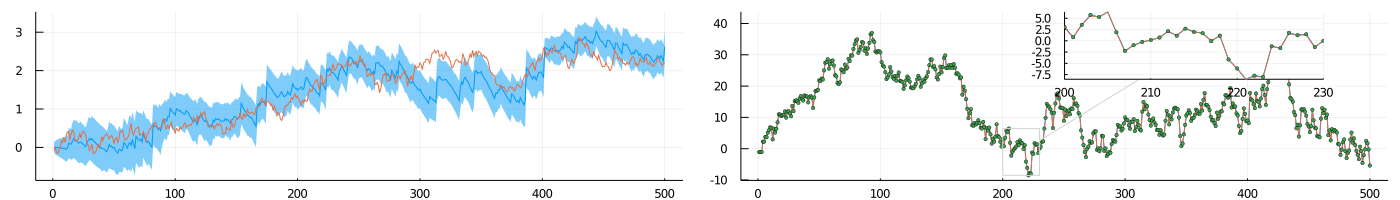

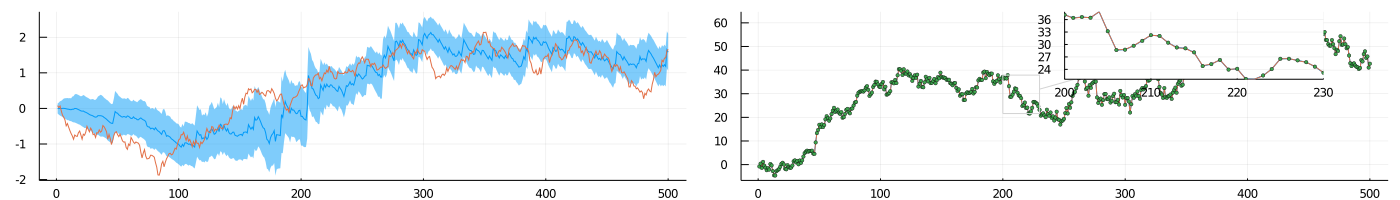

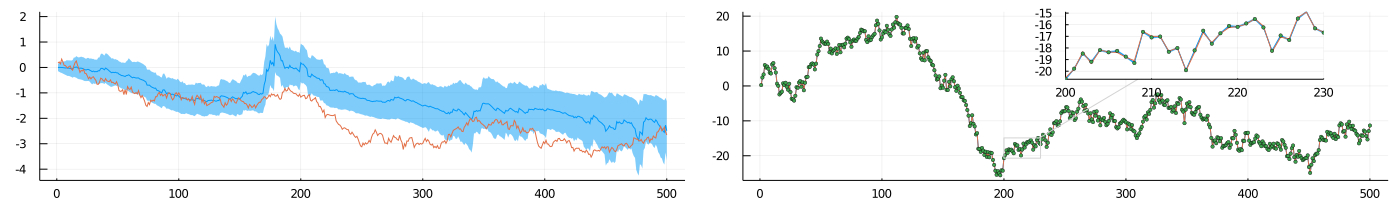

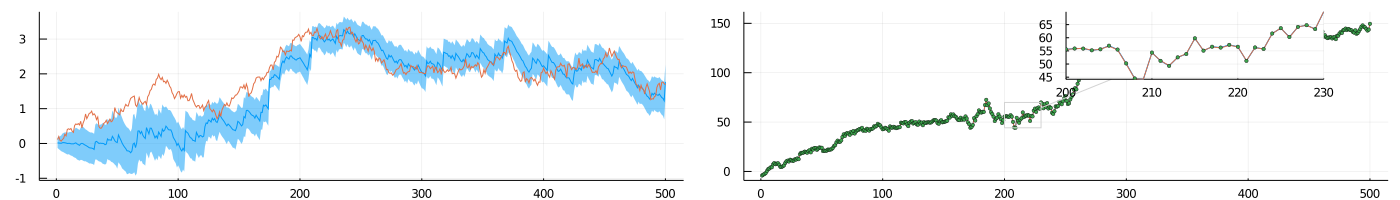

In [60]:
for i in 1:ndim
    display(plot_dimension(mz, mx, y, i))
end

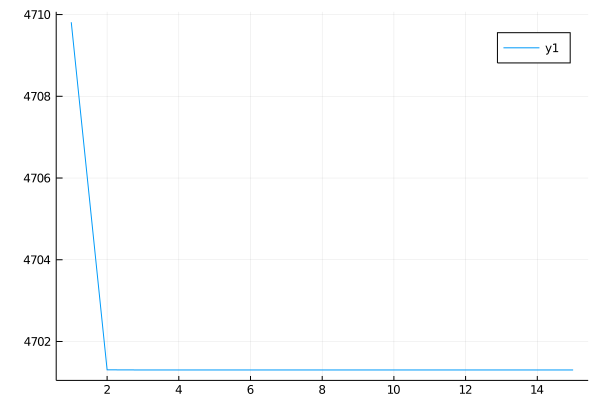

In [61]:
plot(fe)

In [64]:
results = Dict(
    :n      => n,
    :iters  => iters,
    :x_m    => mean.(mx),
    :x_v    => var.(mx),
    :z_m    => mean.(mz),
    :z_v    => var.(mz),
    :fe     => fe,
    :ndim   => ndim,
    :y      => y,
    :x      => x,
    :z      => z,
    :kernel => "0.01 * (kernelmatrix(gkernel, d) + Diagonal(2.0 * ones(ndim)) + Diagonal(exp.(d)))",
    :z_cov  => string(z_covariance),
    :y_cov  => string(y_covariance)
);

In [63]:
results

Dict{Symbol,Any} with 12 entries:
  :z_m    => [[-3.59331e-5, -0.000332323, -0.000308483, 0.000705284], [-0.00014…
  :z_cov  => "[0.01 0.0 0.0 0.0; 0.0 0.01 0.0 0.0; 0.0 0.0 0.01 0.0; 0.0 0.0 0.…
  :ndim   => 4
  :x_m    => [[0.0163111, 0.00607649, 0.0244872, 0.0317318], [-0.0318245, 0.019…
  :kernel => "0.01 * (kernelmatrix(gkernel, d) + Diagonal(2.0 * ones(ndim)) + D…
  :x      => [[-0.143221, -0.0820664, 0.0537483, -0.559577], [-0.129072, 0.0761…
  :y_cov  => "[2.2968710680719595 0.0 0.0 0.0; 0.0 1.0823965162662148 0.0 0.0; …
  :z_v    => [[0.0199117, 0.0200959, 0.0199818, 0.0199748], [0.0297777, 0.03020…
  :fe     => [5472.34, 5315.57, 5392.15, 5430.9, 5445.35, 5456.86, 5466.69, 547…
  :z      => [[-0.08117, 0.0789131, 0.177057, 0.111471], [0.00182592, 0.0220216…
  :y      => [[0.399353, -0.0873755, 1.44002, 1.86711], [-1.464, 0.289506, 1.21…
  :x_v    => [[0.0488315, 0.0477295, 0.0492343, 0.0491555], [0.0851128, 0.08089…

In [40]:
using JSON3

In [31]:
name   = "smoothing_500_SNR_1_SR"
folder = "for_gcv_paper"

"for_gcv_paper"

In [33]:
open(string("./", folder, "/", name, ".json"), "w") do io
    write(io, JSON3.write(results))
end

9

In [60]:
inv(2)

0.5

In [63]:
size(MvNormal([ 1, 2], [ 2 -1; -1 2 ]))

(2,)

In [21]:
using ReactiveMP
using LinearAlgebra

In [25]:
a = MvNormalMeanPrecision([ 1, 2 ], [ 2 -1; -1 2 ])

MvNormalMeanPrecision(
μ: [1, 2]
Λ: [2.0 -1.0; -1.0 2.0]
)


In [23]:
Revise.retry()

In [13]:
multiply_messages(a |> as_message, a |> as_message)

Message{MvNormalMeanPrecision{Float64,Array{Float64,1},PDMats.PDMat{Float64,Array{Float64,2}}}}(MvNormalMeanPrecision(
μ: [1.0000000000000002, 2.0000000000000004]
Λ: [4.0 -2.0; -2.0 4.0]
)
)

In [18]:
Distributions.entropy(a)

2.288570922075291

In [16]:
import Distributions